In [36]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [9]:
def load_csv_file(filepath,filename):
    """
    Load a CSV file into a pandas DataFrame.
    
    Parameters:
    - filepath: str, the path to the directory containing the CSV file.
    - filename: str, the name of the CSV file to load.
    
    Returns:
    - df: pandas DataFrame containing the data from the CSV file.
    """
    full_path = os.path.join(filepath,filename)
    df = pd.read_csv(full_path, index_col=0)
    
    # Convert 'time' column to datetime if it exists
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
    
    return df

def load_config_file(filepath = os.path.join(os.getcwd(), "..",'config'), filename="config.yaml"):
    """
    Load a YAML configuration file.
    
    Parameters:
    - filepath: str, the path to the directory containing the YAML file.
    - filename: str, the name of the YAML file to load.
    
    Returns:
    - config: dict, the configuration loaded from the YAML file.
    """
    import yaml
    
    full_path = os.path.join(filepath, filename)
    with open(full_path, 'r') as file:
        config = yaml.safe_load(file)
    
    return config


### Import the data and config

In [17]:
config = load_config_file()
df = load_csv_file(os.path.join(os.getcwd(), "..", 'Data',"input"), config['input_file_name'])
df.head()

,group,age,gender,location,previous_purchases,email_version,click,conversion
user_id,,,,,,,,
1,A,21,M,TX,1,Text-heavy,0,0
2,B,24,M,IL,1,Image-rich,1,0
3,A,52,M,IL,1,Text-heavy,0,0
4,A,26,M,NY,0,Text-heavy,0,0
5,A,25,M,IL,3,Text-heavy,0,0


## EDA

- Step 1 : Groups (A or B) are based on the email_version. Check the one-to-one mapping properly.
- Step 2 : Age demographics

In [20]:


def check_one_to_one_relationship(df, column1, column2):
    """
    Check if there is a one-to-one relationship between two columns in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: str, the first column to check.
    - column2: str, the second column to check.
    
    Returns:
    - bool: True if there is a one-to-one relationship, False otherwise.
    """
    return df[column1].nunique() == df[column2].nunique() and df[column1].nunique() == df[[column1, column2]].drop_duplicates().shape[0]

print("Checking one-to-one relationship between 'group' and 'email_version':")
if check_one_to_one_relationship(df, 'group', 'email_version'):
    print("There is redundancy in the 'group' and 'email_version' columns.")
df[["group","email_version"]].drop_duplicates()

Checking one-to-one relationship between 'group' and 'email_version':
There is redundancy in the 'group' and 'email_version' columns.


,group,email_version
user_id,,
1,A,Text-heavy
2,B,Image-rich


In [31]:

def plot_histogram(series, bins=20, title="Histogram", xlabel="Value", ylabel="Frequency"):
    """
    Plot a histogram of a pandas Series.
    
    Parameters:
    - series: pandas Series to plot.
    - bins: int, number of bins for the histogram.
    - title: str, title of the histogram.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    """
    plt.hist(series, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
def plot_boxplot(df, x, y, title="Boxplot", xlabel="X-axis", ylabel="Y-axis"):
    """
    Plot a boxplot with overlaid scatter of data points.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - x: str, the column to use for the x-axis.
    - y: str, the column to use for the y-axis.
    - title: str, title of the boxplot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=x, y=y, data=df, showfliers=False)
    sns.stripplot(x=x, y=y, data=df, color='black', alpha=0.3, jitter=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_kde_distribution(df, column, title="Kernel Density Estimate", xlabel="Value", ylabel="Density"):
    """
    Plot a kernel density estimate (KDE) of a specified column in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - column: str, the column to plot.
    - title: str, title of the KDE plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    """
    sns.kdeplot(df[column], fill=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



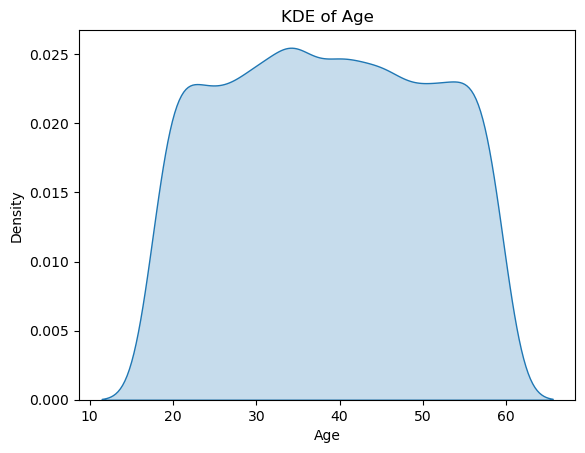

In [32]:
plot_kde_distribution(df, 'age', title="KDE of Age", xlabel="Age", ylabel="Density")

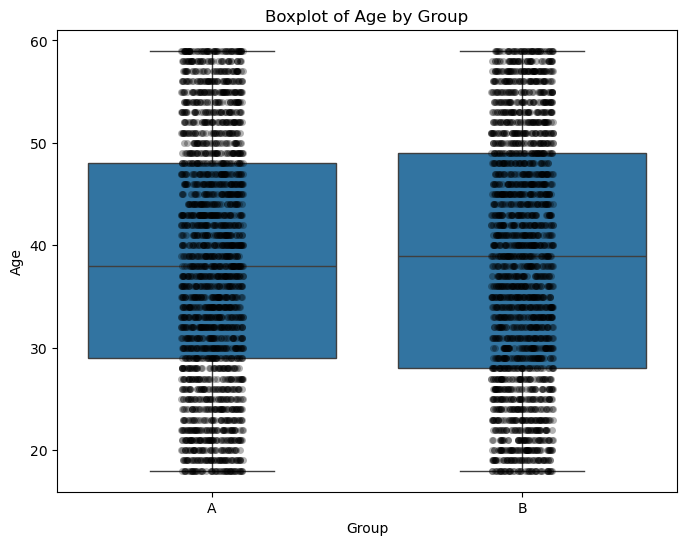

In [33]:
plot_boxplot(df,x = 'group', y = 'age', title="Boxplot of Age by Group", xlabel="Group", ylabel="Age")

In [35]:
df['age'].describe()

count    5000.000000
mean       38.510800
std        12.002462
min        18.000000
25%        28.000000
50%        38.000000
75%        49.000000
max        59.000000
Name: age, dtype: float64

### Struge's rule for number of bins

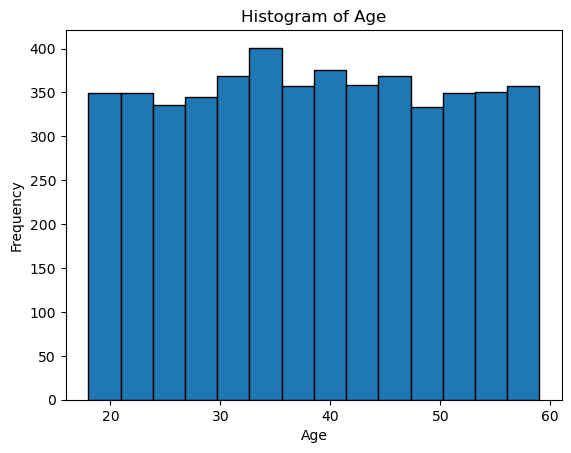

In [37]:


bin_count = math.ceil(np.log2(len(df['age'])) + 1)

plot_histogram(df['age'], bins=bin_count, title="Histogram of Age", xlabel="Age", ylabel="Frequency")


In [48]:

df['age_bins'] = pd.cut(df['age'], bins=bin_count)

# Create new labels with integer intervals
bin_edges = df['age_bins'].cat.categories
int_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in bin_edges]

# Assign the new labels
df['age_bins'] = pd.cut(df['age'], bins=bin_count, labels=int_labels, include_lowest=True)

df['age_bins'].value_counts().sort_index()


age_bins
17-20    349
20-23    349
23-26    336
26-29    345
29-32    369
32-35    401
35-38    357
38-41    376
41-44    359
44-47    369
47-50    334
50-53    349
53-56    350
56-59    357
Name: count, dtype: int64

In [52]:
grouped_df = df.groupby(['group','age_bins'])[["click","conversion"]].mean().reset_index()
grouped_df.rename(columns={"click": "CTR", "conversion": "conversion_rate"}, inplace=True)
grouped_df = grouped_df.sort_values(by=["conversion_rate"], ascending=[False])
grouped_df

C:\Users\satwik.boina\AppData\Local\Temp\ipykernel_30116\4199276235.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['group','age_bins'])[["click","conversion"]].mean().reset_index()


,group,age_bins,CTR,conversion_rate
18,B,29-32,0.260116,0.052023
15,B,20-23,0.220238,0.041667
26,B,53-56,0.219653,0.040462
16,B,23-26,0.208092,0.034682
23,B,44-47,0.218750,0.031250
22,B,41-44,0.250000,0.030488
2,A,23-26,0.171779,0.024540
24,B,47-50,0.174419,0.023256
13,A,56-59,0.132948,0.023121
27,B,56-59,0.222826,0.021739
